# Problem Statement

In this assignment you will experiment with the [Dakshina dataset](https://github.com/google-research-datasets/dakshina) released by Google. This dataset contains pairs of the following form: 

$x$.      $y$

ajanabee अजनबी.

i.e., a word in the native script and its corresponding transliteration in the Latin script (the way we type while chatting with our friends on WhatsApp etc). Given many such $(x_i, y_i)_{i=1}^n$ pairs your goal is to train a model $y = \hat{f}(x)$ which takes as input a romanized string (ghar) and produces the corresponding word in Devanagari (घर). 

As you would realise this is the problem of mapping a sequence of characters in one language to a sequence of characters in another language. Notice that this is a scaled down version of the problem of translation where the goal is to translate a sequence of **words** in one language to a sequence of words in another language (as opposed to sequence of **characters** here).

Read these blogs to understand how to build neural sequence to sequence models: [blog1](https://keras.io/examples/nlp/lstm_seq2seq/), [blog2](https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/)

In [ ]:
#This cell contains necessary code for dataset preprocessing and at the I print few examples for looking how the dataset looks like
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

trainPth = "/mnt/e_disk/DA6401_Assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv"
devPth   = "/mnt/e_disk/DA6401_Assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv"
testPth = "/mnt/e_disk/DA6401_Assignment3/dataset/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv"
def get_vocab(paths):
    chars = set()
    for path in paths:
        with open(path, encoding="utf-8") as f:
            for line in f:
                native, roman, _ = line.strip().split("\t")
                chars.update(native)
                chars.update(roman)
    return chars

def get_char2idx(char_set):
    chars = ["<pad>", "<sos>", "<eos>", "<unk>"] + sorted(char_set)
    return {ch: i for i, ch in enumerate(chars)}, chars

char_set = get_vocab([trainPth, devPth])
roman2idx, idx2roman = get_char2idx(set(c for c in char_set if c.isascii()))
dev2idx, idx2dev = get_char2idx(set(c for c in char_set if not c.isascii()))

class TranslitDataset(Dataset):
    def __init__(self, path, src_c2i, tgt_c2i, max_len=32):
        self.data = []
        with open(path, encoding="utf-8") as f:
            for line in f:
                native, roman, _ = line.strip().split("\t")
                self.data.append((roman, native))
        self.src_c2i = src_c2i
        self.tgt_c2i = tgt_c2i
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        roman, native = self.data[i]
        src = [self.src_c2i.get(c, self.src_c2i["<unk>"]) for c in roman[:self.max_len]]
        tgt = [self.tgt_c2i["<sos>"]] + \
              [self.tgt_c2i.get(c, self.tgt_c2i["<unk>"]) for c in native[:self.max_len - 1]] + \
              [self.tgt_c2i["<eos>"]]
        return torch.tensor(src), torch.tensor(tgt)

def pad_batch(batch):
    src, tgt = zip(*batch)
    src = pad_sequence(src, batch_first=True, padding_value=roman2idx["<pad>"])
    tgt = pad_sequence(tgt, batch_first=True, padding_value=dev2idx["<pad>"])
    return src, tgt

train_ds = TranslitDataset(trainPth, roman2idx, dev2idx, max_len=32)
dev_ds   = TranslitDataset(devPth, roman2idx, dev2idx, max_len=32)
test_ds   = TranslitDataset(testPth, roman2idx, dev2idx, max_len=32)

print("Train set")
for i in range(5):
    src, tgt = train_ds[i]
    roman = ''.join([idx2roman[idx] for idx in src])
    native = ''.join([idx2dev[idx] for idx in tgt[1:-1]])  # skip <sos> and <eos>
    print(f"{i+1}. Roman: {roman:20s}  →  Native: {native}")
print("Dev set")
for i in range(5):
    src, tgt = dev_ds[i]
    roman = ''.join([idx2roman[idx] for idx in src])
    native = ''.join([idx2dev[idx] for idx in tgt[1:-1]])
    print(f"{i+1}. Roman: {roman:20s}  →  Native: {native}")


Train set
1. Roman: fiat                  →  Native: ஃபியட்
2. Roman: phiyat                →  Native: ஃபியட்
3. Roman: piyat                 →  Native: ஃபியட்
4. Roman: firaans               →  Native: ஃபிரான்ஸ்
5. Roman: france                →  Native: ஃபிரான்ஸ்
Dev set
1. Roman: fire                  →  Native: ஃபயர்
2. Roman: phayar                →  Native: ஃபயர்
3. Roman: baar                  →  Native: ஃபார்
4. Roman: bar                   →  Native: ஃபார்
5. Roman: far                   →  Native: ஃபார்


## Question 1 (15 Marks)
Build a RNN based seq2seq model which contains the following layers: (i) input layer for character embeddings (ii) one encoder RNN which sequentially encodes the input character sequence (Latin) (iii) one decoder RNN which takes the last state of the encoder as input and produces one output character at a time (Devanagari). 

The code should be flexible such that the dimension of the input character embeddings, the hidden states of the encoders and decoders, the cell (RNN, LSTM, GRU) and the number of layers in the encoder and decoder can be changed.

(a) What is the total number of computations done by your network? (assume that the input embedding size is $m$, encoder and decoder have 1 layer each, the hidden cell state is $k$ for both the encoder and decoder, the length of the input and output sequence is the same, i.e., $T$, the size of the vocabulary is the same for the source and target language, i.e., $V$)

(b) What is the total number of parameters in your network? (assume that the input embedding size is $m$, encoder and decoder have 1 layer each, the hidden cell state is $k$ for both the encoder and decoder and the length of the input and output sequence is the same, i.e., $T$, the size of the vocabulary is the same for the source and target language, i.e., $V$)

In [ ]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, cell_type='LSTM'):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        self.rnn = rnn_cls(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.cell_type = cell_type

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return hidden  

# Note: hidden is tuple if LSTM, a tensor otherwise..

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, cell_type='LSTM'):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[cell_type]
        self.rnn = rnn_cls(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.cell_type = cell_type

    def forward(self, input, hidden):
        # input: [batch_size]
        input = input.unsqueeze(1)  # [batch_size, 1]
        embedded = self.embedding(input)  # [batch_size, 1, emb_dim]
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))  # [batch_size, output_dim]
        return prediction, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, cell_type='LSTM'):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.cell_type = cell_type

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size, tgt_len = tgt.shape
        tgt_vocab_size = self.decoder.embedding.num_embeddings

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        hidden = self.encoder(src)

# First input to decoder is a <sos> token

        input = tgt[:, 0]

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = tgt[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs


(a) What is the total number of computations done by your network? (assume that the input embedding size is $m$, encoder and decoder have 1 layer each, the hidden cell state is $k$ for both the encoder and decoder, the length of the input and output sequence is the same, i.e., $T$, the size of the vocabulary is the same for the source and target language, i.e., $V$)

Given: 
- Input embedding size: m

- Hidden size (encoder and decoder): k

- Input and output sequence length: T

- Vocabulary size (same for source and target): V

- One encoder layer and one decoder layer

- Model uses LSTM / GRU / RNN cells

- Encoder:
    - RNN: Cost per step=m⋅k+k⋅k=k(m+k)
    - LSTM: Cost per step=4[k(m+k)]=4k(m+k) DUE TO 4 gates
    - GRU: Cost per step=3k(m+k)
    - Total cost for encoder = T⋅(cost per step)

- Decoder:
    - RNN: Cost per step=m⋅k+k⋅k=k(m+k)
    - LSTM: Cost per step=4[k(m+k)]=4k(m+k) DUE TO 4 gates
    - GRU: Cost per step=3k(m+k)
    - Output projection cost per step: Hidden→Vocab:k⋅V
    - Total cost for decoder = T⋅[RNN cost per step+k⋅V]

- Total cost = 
    - RNN = T⋅[2k(m+k)+kV]
    - LSTM = T⋅[8k(m+k)+kV]
    - GRU = T⋅[6k(m+k)+kV]

(b) What is the total number of parameters in your network? (assume that the input embedding size is $m$, encoder and decoder have 1 layer each, the hidden cell state is $k$ for both the encoder and decoder and the length of the input and output sequence is the same, i.e., $T$, the size of the vocabulary is the same for the source and target language, i.e., $V$)

Given:
- Embedding size = m
- Number of layers in encoder and decoder = 1
- Hidden state size = k (both encoder and decoder)
- Sequence length = T (same for input and output, but sequence length does not affect the number of parameters)
- Vocabulary size (source and target) = V

- Pareameters in Embedding layer:
    - Encoder Embedding: params=V×m
    - Decoder Embedding: params=V×m
    - Total Embedding params = 2*V*m

- Parameters in RNN Layers
    - If LSTM:
        - encoder LSTM params=4k(m+k+1)
        - decoder LSTM params=4k(m+k+1)
        - Linear Layer params=kV+V=V(k+1)
        - Total = 2Vm + 8k(m+k+1)+V(k+1)
    - If GRU:
        - encoder GRU params=3k(m+k+1)
        - decoder GRU params=3k(m+k+1)
        - Linear Layer params=kV+V=V(k+1)
        - Total = 2Vm + 6k(m+k+1)+V(k+1)
    - If RNN:
        - encoder RNN params=k(m+k+1)
        - decoder RNN params=k(m+k+1)
        - Linear Layer params=kV+V=V(k+1)
        - Total = 2Vm + 2k(m+k+1)+V(k+1)



# Question 2 (10 Marks)

You will now train your model using any one language from the [Dakshina dataset](https://github.com/google-research-datasets/dakshina) (I would suggest pick a language that you can read so that it is easy to analyse the errors). Use the standard train, dev, test set from the folder dakshina_dataset_v1.0/hi/lexicons/ (replace hi by the language of your choice)

Using the sweep feature in wandb find the best hyperparameter configuration. Here are some suggestions but you are free to decide which hyperparameters you want to explore

- input embedding size: 16, 32, 64, 256, ...
- number of encoder layers: 1, 2, 3 
- number of decoder layers: 1, 2, 3 
- hidden layer size: 16, 32, 64, 256, ...
- cell type: RNN, GRU, LSTM
- dropout: 20%, 30% (btw, where will you add dropout? you should read up a bit on this)
- beam search in decoder with different beam sizes: 

Based on your sweep please paste the following plots which are automatically generated by wandb:
- accuracy v/s created plot (I would like to see the number of experiments you ran to get the best configuration). 
- parallel co-ordinates plot
- correlation summary table (to see the correlation of each hyperparameter with the loss/accuracy)

Also write down the hyperparameters and their values that you sweeped over. Smart strategies to reduce the number of runs while still achieving a high accuracy would be appreciated. Write down any unique strategy that you tried for efficiently searching the hyperparameters.


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import wandb
from torch.utils.data import DataLoader, Dataset

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers, cell_type):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = getattr(nn, cell_type.upper())(emb_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return hidden

# Define Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers, cell_type):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = getattr(nn, cell_type.upper())(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, input, hidden):
        if input.dim() == 1:
            input = input.unsqueeze(1)
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

# Define Seq2Seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.shape
        output_dim = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, trg_len, output_dim).to(self.device)

        hidden = self.encoder(src)
        input = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs

def trim_eos(seq, eos_idx):
    seq = seq.tolist()
    if eos_idx in seq:
        return seq[:seq.index(eos_idx)]
    return seq

def evaluate(model, input_seq, eos_idx, device):
    model.eval()
    with torch.no_grad():
        hidden = model.encoder(input_seq.unsqueeze(0))
        input_token = input_seq[0].view(1) # <sos>
        decoded = []

        for _ in range(input_seq.shape[0]):
            output, hidden = model.decoder(input_token, hidden)
            top1 = output.argmax(1)
            if top1.item() == eos_idx:
                break
            decoded.append(top1.item())
            input_token = top1.unsqueeze(0)

    return decoded

def calc_word_accuracy(model, loader, eos_idx, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            for i in range(src.size(0)):
                pred_seq = evaluate(model, src[i], eos_idx, device)
                true_seq = trim_eos(tgt[i][1:], eos_idx)
                if pred_seq == true_seq:
                    correct += 1
                total += 1
    return correct / total if total > 0 else 0

def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = f"cell_{config.cell_type}/hid_{config.hidden_dim}/emb_{config.emb_dim}/lay_{config.num_layers}/lr_{config.lr}"

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, collate_fn=pad_batch)
        dev_loader   = DataLoader(dev_ds, batch_size=config.batch_size, shuffle=False, collate_fn=pad_batch)

        vocab_size_input = len(roman2idx)
        vocab_size_output = len(dev2idx)

        encoder = Encoder(vocab_size_input, config.emb_dim, config.hidden_dim, config.num_layers, config.cell_type)
        decoder = Decoder(vocab_size_output, config.emb_dim, config.hidden_dim, config.num_layers, config.cell_type)
        model = Seq2Seq(encoder, decoder, device).to(device)

        optimizer = opt.Adam(model.parameters(), lr=config.lr)
        criterion = nn.CrossEntropyLoss(ignore_index=dev2idx["<pad>"])

        best_val_loss = float('inf')
        save_path = os.path.join(wandb.run.dir, 'best_model.pth')
        eos_idx = dev2idx["<eos>"]

        for epoch in range(config.epochs):
            model.train()
            train_loss = 0
            token_correct = 0
            token_total = 0

            for src, tgt in train_loader:
                src, tgt = src.to(device), tgt.to(device)
                optimizer.zero_grad()
                output = model(src, tgt, teacher_forcing_ratio=0.5)

                output_flat = output[:, 1:].reshape(-1, vocab_size_output)
                tgt_flat = tgt[:, 1:].reshape(-1)
                loss = criterion(output_flat, tgt_flat)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * src.size(0)

                preds = output_flat.argmax(1)
                mask = tgt_flat != dev2idx["<pad>"]
                token_correct += ((preds == tgt_flat) & mask).sum().item()
                token_total += mask.sum().item()

            train_loss /= len(train_ds)
            train_token_acc = token_correct / token_total if token_total > 0 else 0
            # train_word_acc = calc_word_accuracy(model, train_loader, eos_idx, device)

            val_loss = 0
            val_token_correct = 0
            val_token_total = 0

            model.eval()
            with torch.no_grad():
                for src, tgt in dev_loader:
                    src, tgt = src.to(device), tgt.to(device)
                    output = model(src, tgt, teacher_forcing_ratio=0.0)

                    output_flat = output[:, 1:].reshape(-1, vocab_size_output)
                    tgt_flat = tgt[:, 1:].reshape(-1)
                    loss = criterion(output_flat, tgt_flat)
                    val_loss += loss.item() * src.size(0)

                    preds = output_flat.argmax(1)
                    mask = tgt_flat != dev2idx["<pad>"]
                    val_token_correct += ((preds == tgt_flat) & mask).sum().item()
                    val_token_total += mask.sum().item()

            val_loss /= len(dev_ds)
            val_token_acc = val_token_correct / val_token_total if val_token_total > 0 else 0
            val_word_acc = calc_word_accuracy(model, dev_loader, eos_idx, device)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), save_path)
                artifact = wandb.Artifact('best-model', type='model')
                artifact.add_file(save_path)
                wandb.log_artifact(artifact)

            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_token_accuracy': train_token_acc,
                # 'train_word_accuracy': train_word_acc,
                'val_token_accuracy': val_token_acc,
                'val_word_accuracy': val_word_acc
            })

# Sweep config
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_loss', 'goal': 'minimize'},
    'parameters': {
        'epochs': {'values': [10, 15, 20]},
        'emb_dim': {'values': [64, 128]},
        'hidden_dim': {'values': [128, 256]},
        'num_layers': {'values': [1, 2]},
        'cell_type': {'values': ['RNN', 'GRU', 'LSTM']},
        'lr': {'values': [1e-3, 1e-4]},
        'batch_size': {'values': [32, 64]}
    }
}

sweep_id = wandb.sweep(sweep_config, project='Assignment3')
wandb.agent(sweep_id, function=train_model, count=15)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: d7qd4jns
Sweep URL: https://wandb.ai/navaneeth001/Assignment3/sweeps/d7qd4jns


wandb: Agent Starting Run: fyk2bpuz with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	emb_dim: 128
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 2
wandb: Currently logged in as: navaneeth001 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train_token_accuracy,▁▆▇▇▇▇█████████
val_loss,█▃▁▁▁▂▂▂▂▃▃▄▄▅▄
val_token_accuracy,▁▅▇▇███████▇███
val_word_accuracy,▁▄▇█▇▆▇▆▆▆▃▄▄▃▂
epoch,15
train_loss,0.16675
train_token_accuracy,0.95951
val_loss,1.17045
val_token_accuracy,0.78039


wandb: Agent Starting Run: fngbvqhg with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	emb_dim: 64
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▆▅▄▄▃▃▂▂▂▁▁▁▁
train_token_accuracy,▁▂▃▄▄▅▆▆▇▇▇▇███
val_loss,█▇▆▆▅▄▄▃▃▂▂▂▁▁▁
val_token_accuracy,▁▂▃▃▄▄▅▅▆▇▇▇▇██
val_word_accuracy,▁▁▁▁▁▂▂▃▄▅▆▆▇▇█
epoch,15
train_loss,0.69221
train_token_accuracy,0.81824
val_loss,1.16258
val_token_accuracy,0.70539


wandb: Agent Starting Run: 5ljyayfz with config:
wandb: 	batch_size: 64
wandb: 	cell_type: LSTM
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▅▄▃▂▂▁▁
train_token_accuracy,▁▂▃▄▅▆▆▇▇█
val_loss,█▇▆▆▅▄▃▂▂▁
val_token_accuracy,▁▂▂▃▄▄▅▆▇█
val_word_accuracy,▁▁▁▁▂▂▃▆▇█
epoch,10
train_loss,1.17238
train_token_accuracy,0.66236
val_loss,1.7206
val_token_accuracy,0.50939


wandb: Agent Starting Run: sce2m7rr with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▃▂▂▁▁
train_token_accuracy,▁▂▃▄▅▆▇▇██
val_loss,█▇▆▅▄▃▂▂▁▁
val_token_accuracy,▁▂▃▄▅▆▇▇██
val_word_accuracy,▁▁▁▂▂▃▅▆▇█
epoch,10
train_loss,0.76835
train_token_accuracy,0.79555
val_loss,1.27734
val_token_accuracy,0.66522


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: piiuub04 with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wandb: 	emb_dim: 64
wandb: 	epochs: 20
wandb: 	hidden_dim: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_token_accuracy,▁▄▆▆▇▇▇▇▇▇██████████
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_token_accuracy,▁▄▅▆▇▇▇█████████████
val_word_accuracy,▁▂▄▅▆▆▇▇▇███████████
epoch,20
train_loss,0.1721
train_token_accuracy,0.9603
val_loss,1.00347
val_token_accuracy,0.79854


wandb: Agent Starting Run: kp14xrit with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	emb_dim: 64
wandb: 	epochs: 20
wandb: 	hidden_dim: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_token_accuracy,▁▃▄▆▆▇▇▇▇▇██████████
val_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_token_accuracy,▁▂▄▅▆▇▇▇▇███████████
val_word_accuracy,▁▁▂▃▅▆▆▇▇▇▇█▇███████
epoch,20
train_loss,0.25684
train_token_accuracy,0.93932
val_loss,0.89119
val_token_accuracy,0.80898


wandb: Agent Starting Run: 9wc7bwkg with config:
wandb: 	batch_size: 64
wandb: 	cell_type: GRU
wandb: 	emb_dim: 128
wandb: 	epochs: 20
wandb: 	hidden_dim: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_token_accuracy,▁▃▅▆▇▇▇▇▇███████████
val_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_token_accuracy,▁▃▅▆▇▇▇█████████████
val_word_accuracy,▁▂▃▅▆▆▇▇█▇▇██▇▇█████
epoch,20
train_loss,0.21066
train_token_accuracy,0.95106
val_loss,0.94912
val_token_accuracy,0.80339


wandb: Agent Starting Run: sr6wltvu with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	emb_dim: 128
wandb: 	epochs: 20
wandb: 	hidden_dim: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_token_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████
val_loss,█▃▄▃▂▃▃▂▁▃▁▂▂▂▂▂▁▂▄▃
val_token_accuracy,▁▇▅▇▆▅▆▆▇▇█▆▇▇▆██▇▅▆
val_word_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,2.09554
train_token_accuracy,0.38487
val_loss,2.78007
val_token_accuracy,0.19471


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3f8enbac with config:
wandb: 	batch_size: 32
wandb: 	cell_type: GRU
wandb: 	emb_dim: 128
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▆▅▃▃▂▂▂▂▁▁▁▁▁▁
train_token_accuracy,▁▃▄▅▆▇▇▇▇██████
val_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁
val_token_accuracy,▁▂▃▅▆▆▇▇▇▇█████
val_word_accuracy,▁▁▁▂▃▅▅▆▇▆▇▇▇██
epoch,15
train_loss,0.44334
train_token_accuracy,0.89022
val_loss,0.98237
val_token_accuracy,0.77143


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ervo1spd with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
train_token_accuracy,▁▆▇▇▇█████
val_loss,█▃▂▁▁▂▁▂▂▂
val_token_accuracy,▁▅▇█▇██▇██
val_word_accuracy,▁▇█▇▆▇▄▄▄▃
epoch,10
train_loss,0.2902
train_token_accuracy,0.92941
val_loss,0.99454
val_token_accuracy,0.78744


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fxurdz9z with config:
wandb: 	batch_size: 32
wandb: 	cell_type: RNN
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▁▁▁▁
train_token_accuracy,▁▅▆▆▇▇▇███
val_loss,█▇▇▇▇▅▂▇▆▁
val_token_accuracy,▆▁▁▁▂▆▆▅▁█
val_word_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_loss,2.20838
train_token_accuracy,0.35482
val_loss,2.72317
val_token_accuracy,0.20368


wandb: Agent Starting Run: sy9b7nci with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	emb_dim: 128
wandb: 	epochs: 20
wandb: 	hidden_dim: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_token_accuracy,▁▄▆▆▇▇▇▇▇███████████
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂
val_token_accuracy,▁▄▆▇▇▇██████████████
val_word_accuracy,▁▃▅▅▆▇▇▇▇██████████▇
epoch,20
train_loss,0.14215
train_token_accuracy,0.96685
val_loss,0.96403
val_token_accuracy,0.81368


wandb: Agent Starting Run: g0ol908h with config:
wandb: 	batch_size: 32
wandb: 	cell_type: RNN
wandb: 	emb_dim: 128
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	lr: 0.001
wandb: 	num_layers: 1


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▆▄▄▃▃▂▂▂▁▁▂▁▁▂
train_token_accuracy,▁▃▄▅▅▆▇▇▇█▇▇▇▇▇
val_loss,▃▇▄▄▃▂█▅▇▃▁▃▂▁▁
val_token_accuracy,▄▁▄▃▄▆▃▄▁▅▇▅▇▆█
val_word_accuracy,▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
epoch,15
train_loss,2.21124
train_token_accuracy,0.35178
val_loss,2.87755
val_token_accuracy,0.19318


wandb: Agent Starting Run: 2xds1hqa with config:
wandb: 	batch_size: 32
wandb: 	cell_type: LSTM
wandb: 	emb_dim: 64
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 1


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▃▂▂▂▁▁▁
train_token_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▅▃▂▂▂▁▁▁
val_token_accuracy,▁▃▄▆▆▇▇███
val_word_accuracy,▁▁▂▄▅▇▇▇██
epoch,10
train_loss,0.49973
train_token_accuracy,0.87212
val_loss,1.01247
val_token_accuracy,0.75105


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ejcmr1mq with config:
wandb: 	batch_size: 64
wandb: 	cell_type: RNN
wandb: 	emb_dim: 64
wandb: 	epochs: 20
wandb: 	hidden_dim: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 2


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_token_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▃▂▁▂▃▁▂▃▂▃▂▂▂▂▂▂▃▁▂
val_token_accuracy,▁▆██▇▅▆▆▅▆▇▆▆▇▆▇▆▆▇▇
val_word_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,2.17355
train_token_accuracy,0.36532
val_loss,2.74819
val_token_accuracy,0.1999


# Question 3 (15 Marks)
Based on the above plots write down some insightful observations. For example, 
- RNN based model takes longer time to converge than GRU or LSTM
- using smaller sizes for the hidden layer does not give good results
- dropout leads to better performance 

# Question 4 (10 Marks)

You will now apply your best model on the test data (You shouldn't have used test data so far. All the above experiments should have been done using train and val data only). 

(a) Use the best model from your sweep and report the accuracy on the test set (the output is correct only if it exactly matches the reference output). 

(b) Provide sample inputs from the test data and predictions made by your best model (more marks for presenting this grid creatively). Also upload all the predictions on the test set in a folder **predictions_vanilla** on your github project.

(c) Comment on the errors made by your model (simple insightful bullet points)

- The model makes more errors on consonants than vowels
- The model makes more errors on longer sequences
- I am thinking confusion matrix but may be it's just me!

In [ ]:
import os
import csv
import torch
import wandb
from wandb import Api
from torch.utils.data import DataLoader
from tqdm import tqdm

# === START === 

ENTITY     = 'navaneeth001'
PROJECT    = 'Assignment3'
SWEEP_ID   = 'd7qd4jns'  # ❗ Replace this with actual sweep ID
ARTIFACT_REF = 'navaneeth001/Assignment3/best-model:v151'
OUTPUT_DIR = '/mnt/e_disk/DA6401_Assignment3/predictions_vannila'
CSV_PATH   = os.path.join(OUTPUT_DIR, 'test_predictions.csv')

# === Load best model config from sweep ===
api      = Api()
sweep    = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
runs     = sweep.runs
best_run = min(runs, key=lambda r: r.summary.get('val_loss', float('inf')))
cfg      = best_run.config

eval_run = wandb.init(
    project=PROJECT,
    entity=ENTITY,
    job_type='evaluation'
)
artifact     = eval_run.use_artifact(ARTIFACT_REF, type='model')
download_dir = artifact.download()

# === END === 

model_path   = os.path.join(download_dir, 'best_model.pth') # YOU MAY COPY PASTE THE PATH DIRECTLY FROM THE ARTIFACTS FOLDER IN THIS REPO
print(f"Loaded model artifact to: {model_path}")

# === Load model ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(
    input_dim=len(roman2idx),
    emb_dim=cfg['emb_dim'],
    hidden_dim=cfg['hidden_dim'],
    num_layers=cfg['num_layers'],
    cell_type=cfg['cell_type']
)

decoder = Decoder(
    output_dim=len(dev2idx),
    emb_dim=cfg['emb_dim'],
    hidden_dim=cfg['hidden_dim'],
    num_layers=cfg['num_layers'],
    cell_type=cfg['cell_type']
)

def decode(indices, idx2char, eos_idx=None):
    chars = []
    for idx in indices:
        idx = idx.item()
        if eos_idx is not None and idx == eos_idx:
            break
        if 0 <= idx < len(idx2char):
            chars.append(idx2char[idx])
    return ''.join(chars)



model = Seq2Seq(encoder, decoder, device).to(device)
state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.eval()

# === Prepare test data ===
test_loader = DataLoader(test_ds, batch_size=cfg['batch_size'], shuffle=False, collate_fn=pad_batch)
eos_idx     = dev2idx['<eos>']
pad_idx     = dev2idx['<pad>']

# === Evaluation ===
token_correct = 0
token_total   = 0
word_correct  = 0
word_total    = 0

# Prepare folder and file for saving predictions
os.makedirs(OUTPUT_DIR, exist_ok=True)
pred_rows = [["Input", "Target", "Prediction"]]

with torch.no_grad():
    for src, tgt in tqdm(test_loader, desc="Evaluating"):
        src, tgt = src.to(device), tgt.to(device)
        output = model(src, tgt, teacher_forcing_ratio=0.0)

        output_flat = output[:, 1:].reshape(-1, len(dev2idx))
        tgt_flat    = tgt[:, 1:].reshape(-1)

        preds = output_flat.argmax(1)
        mask  = tgt_flat != pad_idx
        token_correct += ((preds == tgt_flat) & mask).sum().item()
        token_total   += mask.sum().item()

        pred_tokens = output.argmax(2)
        for src_seq, pred_seq, true_seq in zip(src, pred_tokens, tgt):
            input_text = decode(src_seq, idx2roman)
            target_text = decode(true_seq[1:], idx2dev, eos_idx)  # skip <sos>
            pred_text = decode(pred_seq[1:], idx2dev, eos_idx)
            
            pred_rows.append([input_text, target_text, pred_text])
            
            if pred_text == target_text:
                word_correct += 1
            word_total += 1

# === Results ===
token_acc = 100.0 * token_correct / token_total if token_total > 0 else 0.0
word_acc  = 100.0 * word_correct / word_total if word_total > 0 else 0.0

print(f"Test Token Accuracy: {token_acc:.2f}%")
print(f"Test Word Accuracy:  {word_acc:.2f}%")

# === Save predictions to CSV ===
with open(CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(pred_rows)

print(f"Saved predictions to {CSV_PATH}")

# === Log results to wandb ===
wandb.log({
    'test_token_accuracy': token_acc,
    'test_word_accuracy': word_acc
})

eval_run.finish()


wandb:   1 of 1 files downloaded.  


Loaded model artifact to: /mnt/e_disk/DA6401_Assignment3/artifacts/best-model:v151/best_model.pth


Evaluating: 100%|██████████| 108/108 [00:03<00:00, 35.65it/s]

Test Token Accuracy: 78.06%
Test Word Accuracy:  45.00%
Saved predictions to /mnt/e_disk/DA6401_Assignment3/predictions_vannila/test_predictions.csv


test_token_accuracy,▁
test_word_accuracy,▁
test_token_accuracy,78.06337
test_word_accuracy,45.00291


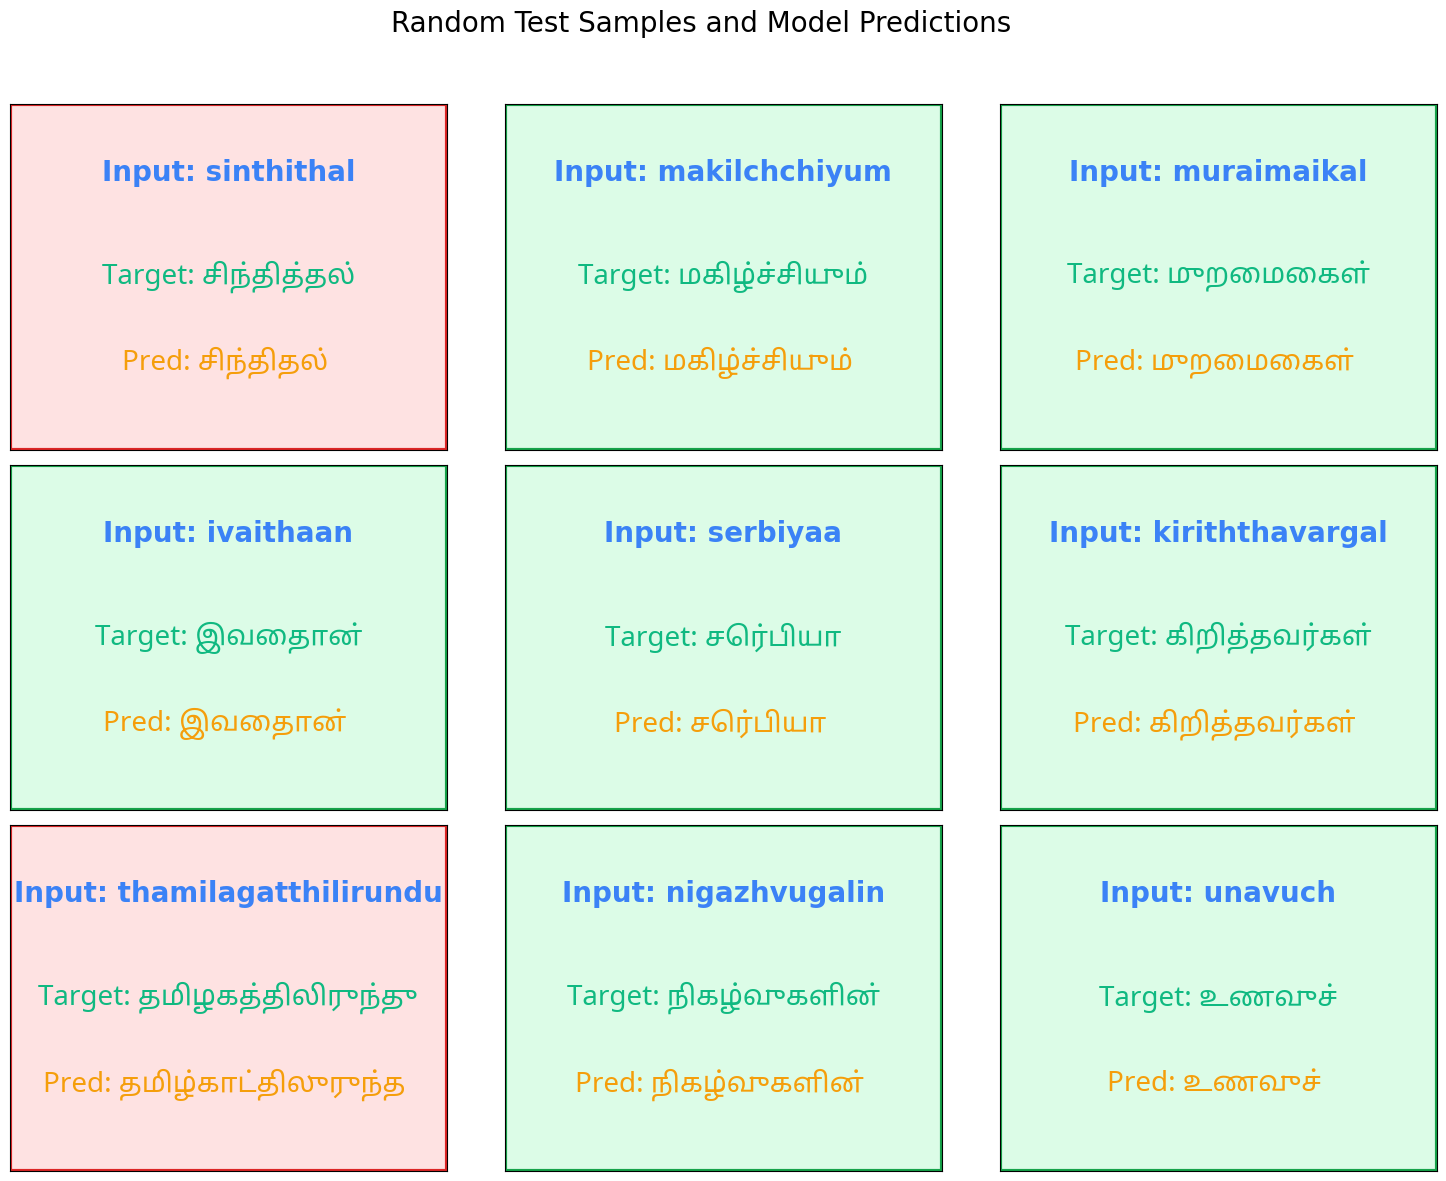

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager as fm
import random
import re

df = pd.read_csv(CSV_PATH)
sampled = df.sample(n=9)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Random Test Samples and Model Predictions", fontsize=20)

colors = {
    "Input": "#3b82f6",       # Blue
    "Target": "#10b981",      # Green
    "Prediction": "#f59e0b"   # Orange
}

tamil_font_path = "/mnt/e_disk/DA6401_Assignment3/NotoSansTamil-VariableFont_wdth,wght.ttf"  # Update path if needed
prop = fm.FontProperties(fname=tamil_font_path)

def clean_text(text):
    """Remove <pad> tokens and strip extra spaces."""
    return re.sub(r'<pad>', '', text).strip()

# === Plot each sample in a grid cell ===
for ax, (_, row) in zip(axes.flat, sampled.iterrows()):
    input_text = clean_text(row["Input"])
    target = clean_text(row["Target"])
    prediction = clean_text(row["Prediction"])
    correct = target == prediction

    bg_color = "#dcfce7" if correct else "#fee2e2"  # greenish or reddish background
    border_color = "#16a34a" if correct else "#dc2626"
  

    # Draw background color and border
    ax.set_facecolor(bg_color)
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, linewidth=3, edgecolor=border_color, facecolor='none'))

    # Display texts
    ax.text(0.5, 0.8, f"Input: {input_text}", color=colors["Input"],
            ha='center', va='center', fontsize=20, fontweight='bold', wrap=True)

    ax.text(0.5, 0.5, f"Target: {target}", color=colors["Target"],
            ha='center', va='center', fontsize=20, fontproperties=prop, wrap=True)

    ax.text(0.5, 0.25, f"Pred: {prediction} ", color=colors["Prediction"],
            ha='center', va='center', fontsize=20, fontproperties=prop, wrap=True)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
